In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_sylvester
from scipy.signal import correlate

In [ ]:
### USEFUL FUNCTIONS ###

def hopf_int(gC, f_diff, sigma):
    """
    Computes the linearized Hopf model.
    
    Parameters:
        gC: Connectivity matrix
        f_diff: Frequency differences
        sigma: Noise variance
    Returns:
        FC: Functional connectivity matrix
        CV: Covariance matrix
        Cvth: Full covariance matrix
        A: Jacobian matrix
    """
    a = -0.02
    N = gC.shape[0]
    wo = f_diff * (2 * np.pi)

    Cvth = np.zeros((2 * N, 2 * N))

    # Jacobian
    s = np.sum(gC, axis=1)
    B = np.diag(s)

    Axx = a * np.eye(N) - B + gC
    Ayy = Axx.copy()
    Axy = -np.diag(wo)
    Ayx = np.diag(wo)

    A = np.block([[Axx, Axy], [Ayx, Ayy]])

    # Noise covariance matrix
    if np.isscalar(sigma):  # Homogeneous noise
        Qn = np.diag([sigma**2] * (2 * N))
    else:  # Heterogeneous noise
        Qn = np.diag(np.concatenate([sigma**2, sigma**2]))

    # Solve Sylvester equation
    Cvth = solve_sylvester(A, A.T, -Qn)

    # Correlation from covariance
    FCth = np.corrcoef(Cvth)
    FC = FCth[:N, :N].copy()
    CV = Cvth[:N, :N].copy()

    return FC, CV, Cvth, A

####################################################################

def plot_FC_matrices(FC1, FC2, title1="FC Matrix 1", title2="FC Matrix 2", cmap="turbo", size=1):
    """
    Plots two functional connectivity matrices side by side, each with its own colorbar.
    
    Parameters:
        FC1 (ndarray): First N x N functional connectivity matrix.
        FC2 (ndarray): Second N x N functional connectivity matrix.
        title1 (str): Title for the first matrix.
        title2 (str): Title for the second matrix.
        cmap (str): Colormap for the heatmaps.
        size (float): Scaling factor for figure size.
    """
    fig, axes = plt.subplots(1, 2, figsize=(8 * size, 3.5 * size))

    # Helper function to set ticks and labels for a given axis
    def set_ticks_and_labels(ax, matrix):
        n = matrix.shape[0]  # Number of regions
        tick_positions = np.arange(n)  # Positions for ticks (0 to n-1)
        # tick_labels = np.arange(1, n + 1)  # Labels starting from 1 to n
        tick_labels = [str(tick_positions[0]+1)] + [''] * (len(tick_positions) - 2) + [str(tick_positions[-1]+1)]
        
        # Set ticks at the center of each square
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        
        # Set tick labels
        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels(tick_labels)

    # Plot the first matrix
    im1 = axes[0].imshow(FC1, cmap=cmap)  # , vmin=-1, vmax=1)
    axes[0].set_title(title1)
    axes[0].set_xlabel("Region Index")
    axes[0].set_ylabel("Region Index")
    cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar1.set_label("Connectivity Strength")
    set_ticks_and_labels(axes[0], FC1)

    # Plot the second matrix
    im2 = axes[1].imshow(FC2, cmap=cmap)  # , vmin=-1, vmax=1)
    axes[1].set_title(title2)
    axes[1].set_xlabel("Region Index")
    cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar2.set_label("Connectivity Strength")
    set_ticks_and_labels(axes[1], FC2)

    plt.tight_layout()
    plt.show()

####################################################################

def create_synthetic_C(N):
    # Step 1: Create a symmetric random matrix
    C = np.random.rand(N, N)  # Generate random values in [0, 1)
    C = (C + C.T) / 2         # Ensure symmetry
    np.fill_diagonal(C, np.random.rand(N))  # Randomize diagonal elements
    
    # Ensure all elements are positive (though they already should be)
    C = np.abs(C)
    
    # Step 2: Modify elements within a 10% range
    modified_C = C.copy()
    for i in range(N):
        for j in range(i, N):  # Only iterate over upper triangle (including diagonal)
            delta = np.random.uniform(-0.1 * C[i, j], 0.1 * C[i, j])  # ±10% range
            modified_C[i, j] += delta
            # modified_C[j, i] = modified_C[i, j]  # Maintain symmetry
            
            # Ensure positivity
            if modified_C[i, j] < 0:
                modified_C[i, j] = 0
                modified_C[j, i] = 0
    
    # Step 3: Normalize the matrix to sum to 0.2
    total_sum = np.sum(modified_C)
    normalized_C = modified_C / total_sum * 0.2
    
    return normalized_C

def create_synthetic_C_diagonally_dominant(N):
    # Step 1: Create a symmetric random matrix
    A = np.random.rand(N, N)  # Generate random values in [0, 1)
    A = (A + A.T) / 2         # Ensure symmetry
    np.fill_diagonal(A, np.random.rand(N))  # Randomize diagonal elements
    
    # Ensure all elements are positive (though they already should be)
    A = np.abs(A)
    
    # Step 2: Modify elements within a 10% range
    modified_A = A.copy()
    for i in range(N):
        for j in range(i, N):  # Only iterate over upper triangle (including diagonal)
            delta = np.random.uniform(-0.1 * A[i, j], 0.1 * A[i, j])  # ±10% range
            modified_A[i, j] += delta
            modified_A[j, i] = modified_A[i, j]  # Maintain symmetry
            
            # Ensure positivity
            if modified_A[i, j] < 0:
                modified_A[i, j] = 0
                modified_A[j, i] = 0
    
    # Step 3: Ensure diagonal dominance
    for i in range(N):
        sum_off_diagonal = np.sum(modified_A[i, :]) - modified_A[i, i]  # Sum of non-diagonal elements
        epsilon = 0.01  # Small positive value to ensure strict inequality
        modified_A[i, i] = sum_off_diagonal + epsilon  # Adjust diagonal element
    
    # Step 4: Normalize the matrix to sum to 0.2
    total_sum = np.sum(modified_A)
    normalized_A = modified_A / total_sum * 0.2
    
    return normalized_A


---
## Create synthetic data to fit

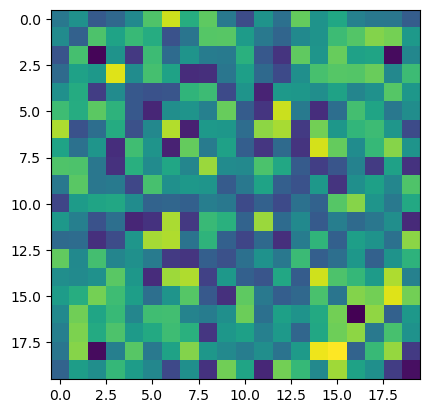

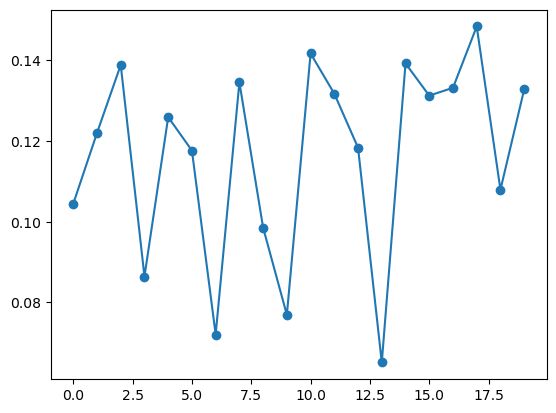

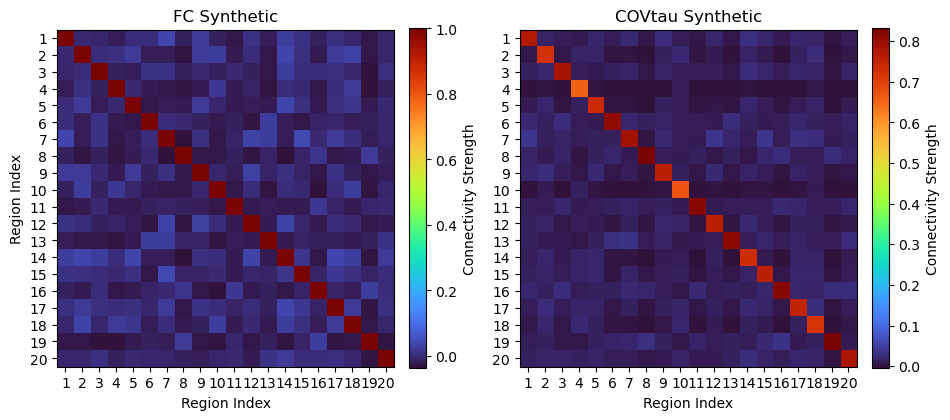

In [93]:
### Generate synthetic data
NPARCELS = 20
Tau = 1
TR = 2

gC = create_synthetic_C(NPARCELS)
f_diff = np.random.uniform(low=0.035, high=0.065, size=NPARCELS)

# Simulate an empirical FC and COVtau using some values for sigma:
sigma_emp = np.random.uniform(low=0.15, high=0.065, size=NPARCELS)

FCemp, COVemp, COVemptotal, A = [arr.copy() for arr in hopf_int(gC, f_diff, sigma_emp)]
COVtauemp = (expm((Tau * TR) * A) @ COVemptotal)[:NPARCELS, :NPARCELS].copy()
sigratiosim = np.zeros((NPARCELS, NPARCELS))
for i in range(NPARCELS):
    for j in range(NPARCELS):
        sigratiosim[i, j] = 1 / np.sqrt(COVemp[i, i]) / np.sqrt(COVemp[j, j])
COVtauemp *= sigratiosim

# Extract the diagonal of the empirical covariance matrix
COVemp_diag = np.diag(COVemp)

### Plot synthetic data
plt.imshow(gC)
plt.show()

plt.plot(sigma_emp,'o-')
plt.show()

plot_FC_matrices(FCemp, COVtauemp, title1="FC Synthetic", title2="COVtau Synthetic", cmap="turbo", size=1.2)


---

## Swarm-based optimization algorithm, such as Particle Swarm Optimization (PSO)
Is a population-based method that can be used to solve optimization problems. PSO is particularly useful for non-convex or complex objective functions because it explores the search space using multiple "particles" that iteratively adjust their positions based on their own best-known position and the global best-known position.

### Step 1: Define the Objective Function 
The goal is to minimize the difference between the calculated FC and the empirical FCemp. A common choice for such problems is the Frobenius norm of the difference between the two matrices: 
$$Error=∥FC−FCemp∥_F​ $$

where $∥⋅∥_F$​ is the Frobenius norm. 



In [94]:
import numpy as np
from scipy.linalg import solve_sylvester, expm

def extended_objective_function(sigma, gC, f_diff, FCemp, COVtauemp, Tau, TR, metric='fro'):
    """
    Computes the combined error for fitting both FC and COVtau.
    
    Parameters:
        sigma: Array of noise variances (3 components)
        gC: Connectivity matrix
        f_diff: Frequency differences
        FCemp: Empirical functional connectivity matrix
        COVtauemp: Empirical covariance matrix at time lag Tau
        Tau: Time lag for COVtau calculation
        TR: Sampling time
        metric: metrics to use
            fro: Frobenius
            mse: Mean Squared Error
            mae: Mean Absolute Error
    
    Returns:
        Total Error: Weighted sum of errors for FC and COVtau
    """

    epsFC = 0.8
    epsCOV = 0.2

    ## Compute the simulated FC, COVsim, and COVtau
    FCsim, COVsim, COVsimtotal, A = hopf_int(gC, f_diff, sigma)
    N = gC.shape[0]
    
    ## Calculate COVtausim
    COVtausim = (expm((Tau * TR) * A) @ COVsimtotal)[:N, :N].copy()
    
    ## Normalize COVtausim
    sigratiosim = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            sigratiosim[i, j] = 1 / np.sqrt(COVsim[i, i]) / np.sqrt(COVsim[j, j])
    COVtausim *= sigratiosim
    
    ## Compute errors
    ## Frobenius
    if metric == 'fro':
        fc_error = np.linalg.norm(FCsim - FCemp, ord='fro')  # Frobenius norm for FC
        covtau_error = np.linalg.norm(COVtausim - COVtauemp, ord='fro')  # Frobenius norm for COVtau
    ## MSE
    if metric == 'mse':
        fc_error = np.mean((FCsim - FCemp) ** 2)  # Mean squared error for FC
        covtau_error = np.mean((COVtausim - COVtauemp) ** 2)  # Mean squared error for COVtau
    ## MAE
    if metric == 'mae':
        fc_error = np.mean(np.abs(FCsim - FCemp))  # Mean absolute error for FC
        covtau_error = np.mean(np.abs(COVtausim - COVtauemp))  # Mean absolute error for COVtau

    ## Combine errors with weights
    total_error = epsFC * fc_error + epsCOV * covtau_error

    
    return total_error

### Step 2: Implement the Particle Swarm Optimization Algorithm

In [95]:
class Particle:
    def __init__(self, bounds, initial_position=None):
        """
        Initialize a particle with either a specified initial position or a random position within bounds.
        
        Parameters:
            bounds: List of tuples [(min, max), ...] specifying the bounds for each dimension.
            initial_position: Optional array-like specifying the initial position of the particle.
        """
        if initial_position is not None:
            # Use the provided initial position (clipped to bounds)
            self.position = np.array([
                np.clip(initial_position[i], bounds[i][0], bounds[i][1]) for i in range(len(bounds))
            ])
        else:
            # Generate a random position within bounds
            self.position = np.array([
                np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(len(bounds))
            ])
        
        # Small initial velocity
        self.velocity = np.random.uniform(-0.1, 0.1, len(bounds))
        
        # Best position and value
        self.best_position = self.position.copy()
        self.best_value = float('inf')

def pso(objective_function, bounds, num_particles=30, max_iter=100, w=0.5, c1=1.5, c2=1.5, args=(), initial_positions=None):
    """
    Perform Particle Swarm Optimization to minimize the objective function.
    
    Parameters:
        objective_function: The function to minimize.
        bounds: List of tuples [(min, max), ...] specifying the bounds for each dimension.
        num_particles: Number of particles in the swarm.
        max_iter: Maximum number of iterations.
        w: Inertia weight.
        c1: Cognitive parameter (influence of particle's best position).
        c2: Social parameter (influence of global best position).
        args: Additional arguments to pass to the objective function.
        initial_positions: Optional list of initial positions for the particles.
                           If provided, overrides random initialization for those particles.
    
    Returns:
        global_best_position: The best solution found.
        global_best_value: The best objective value found.
    """
    # Initialize the swarm
    if initial_positions is not None:
        # Use provided initial positions for the first few particles
        swarm = [
            Particle(bounds, initial_position=initial_positions[i]) if i < len(initial_positions) else Particle(bounds)
            for i in range(num_particles)
        ]
    else:
        # All particles are initialized randomly
        swarm = [Particle(bounds) for _ in range(num_particles)]
    
    # Initialize global best
    global_best_position = None
    global_best_value = float('inf')
    
    # Iterate through generations
    for iteration in range(max_iter):
        for particle in swarm:
            current_value = objective_function(particle.position, *args)
            
            if current_value < particle.best_value:
                particle.best_value = current_value
                particle.best_position = particle.position.copy()
            
            if current_value < global_best_value:
                global_best_value = current_value
                global_best_position = particle.position.copy()
        
        for particle in swarm:
            r1, r2 = np.random.rand(len(bounds)), np.random.rand(len(bounds))
            cognitive_component = c1 * r1 * (particle.best_position - particle.position)
            social_component = c2 * r2 * (global_best_position - particle.position)
            particle.velocity = w * particle.velocity + cognitive_component + social_component
            
            particle.velocity = np.clip(particle.velocity, -0.5, 0.5)
            particle.position += particle.velocity
            
            # Ensure no element of position is zero
            particle.position = np.array([
                np.clip(particle.position[i], max(bounds[i][0], 1e-6), bounds[i][1]) for i in range(len(bounds))
            ])
        
        print(f"Iteration {iteration+1}/{max_iter}, Best Value: {global_best_value}")
    
    return global_best_position, global_best_value

### Step 3: Run the PSO Algorithm
#### Step 3.1: Set notmalization for the optimal_sigma

One common approach is to use the empirical variance  of the signal (or its diagonal elements) as a reference for scaling. The diagonal elements of the covariance matrix (COVsim) correspond to the variances of the individual signals, and these are directly influenced by the scale of sigma. 

Let’s assume: 

    COVemp_diag = np.diag(COVemp) is the vector of empirical variances.
    COVsim_diag = np.diag(COVsim) is the vector of simulated variances obtained from the model.
     

You can enforce a scaling constraint such that the sum of the simulated variances matches the sum of the empirical variances : 
$$ \text{Scale Factor} = \frac{\sum \ \text{COVsim\_diag}}{\sum \ \text{COVemp\_diag​}} $$

Then
$$ \sigma_{\text{norm}} = \sigma_{\text{optimal}} \times \sqrt{\text{Scale Factor}} $$

This ensures that the absolute scale of sigma is consistent with the empirical data. 

In [96]:
## Run PSO ######################################### 
# Define bounds for sigma
bound_min = 1e-4
bound_max = 1
bounds = [(bound_min, bound_max)] * NPARCELS
# Initial guess for sigma
sigma_init_guess = 0.5 * np.ones(NPARCELS)
# Initialization
optimal_sigma = np.zeros(NPARCELS)
# Generate initial positions with random perturbations within the specified percentage
initial_positions = [sigma_init_guess for _ in range(NPARCELS)]
optimal_value_max = 5e-3            # Maximum optimal value tolerance
perturbation_percentage = 20        # Percentage in which sigma_init_guess is randomly modified in each Trial
K_part = 10                         # Particles = K_part * NPARCELS
K_w = 1                             # Inertia = K_w * w
metric = 'fro'                      # Select metric in objective function ('fro', 'mse', 'mae')
#
trial = 1
while (np.any(optimal_sigma == 0) or optimal_value > optimal_value_max ):
    print('--- Trial ', trial)
    num_particles = K_part*NPARCELS
    w = K_w*0.5
    print('+ num_particles =', num_particles)
    print('+ w =', w)
    optimal_sigma, optimal_value = pso(
        objective_function=extended_objective_function,
        bounds=bounds,
        num_particles=num_particles,  # More particles --> better exploration
        max_iter=50,                  # More iterations --> convergence
        w=w,                          # Large inertia weight --> local exploration ; Small inertia weight --> global exploration
        c1=1.5,
        c2=1.5,
        args=(gC, f_diff, FCemp, COVtauemp, Tau, TR, metric),
        initial_positions=initial_positions
    )
    # Set initial guess to last Trial
    sigma_init_guess = optimal_sigma.copy()
    # Generate initial positions with random perturbations within the specified percentage
    # initial_positions = []
    initial_positions = [
        sigma_init_guess * (1 + np.random.uniform(-perturbation_percentage/100, perturbation_percentage/100, len(sigma_init_guess)))
        for _ in range(K_part*NPARCELS)
    ]
    # Increase number of particles
    if K_part < 40:
        K_part += 5
    else:
        K_part += 2
    # Increase global exploration (exit local minimum)
    if w > 0.1:
        K_w *= 0.9
    trial += 1
####################################################

print('---')
print("Optimized objective value:", optimal_value)
print("Optimized sigma:", optimal_sigma)
print('---')
print("TEST FOR PROPORTIONALYTI:")
print("sigma_emp / optimal_sigma =", sigma_emp / optimal_sigma)
print("Multiplicative constant =", np.mean(sigma_emp / optimal_sigma))

# Compute the diagonal of the simulated covariance matrix using the optimized sigma
_, COVsim, _, _ = hopf_int(gC, f_diff, optimal_sigma)
COVsim_diag = np.diag(COVsim)
# Normalize sigma to match the empirical variance
sigma_sum_target = np.sum(COVemp_diag)  # Sum of empirical variances
normalization_factor = sigma_sum_target / np.sum(COVsim_diag)  # Correct normalization factor
sigma_normalized = optimal_sigma * np.sqrt(normalization_factor)
print('---')
print("Normalized sigma:", sigma_normalized)


--- Trial  1
+ num_particles = 200
+ w = 0.5
Iteration 1/50, Best Value: 0.11317659159222991
Iteration 2/50, Best Value: 0.08943980732358986
Iteration 3/50, Best Value: 0.0817272556053933
Iteration 4/50, Best Value: 0.07579882729785495
Iteration 5/50, Best Value: 0.07218412543981598
Iteration 6/50, Best Value: 0.07103261120676078
Iteration 7/50, Best Value: 0.06799723529969344
Iteration 8/50, Best Value: 0.05605494254182209
Iteration 9/50, Best Value: 0.055410119151128166
Iteration 10/50, Best Value: 0.04155013896491756
Iteration 11/50, Best Value: 0.04155013896491756
Iteration 12/50, Best Value: 0.03864101084627857
Iteration 13/50, Best Value: 0.0334614143992502
Iteration 14/50, Best Value: 0.032029005425296894
Iteration 15/50, Best Value: 0.031370722001417224
Iteration 16/50, Best Value: 0.025131152593954955
Iteration 17/50, Best Value: 0.024950946620859612
Iteration 18/50, Best Value: 0.01961304970050255
Iteration 19/50, Best Value: 0.01776337304334705
Iteration 20/50, Best Value: 0

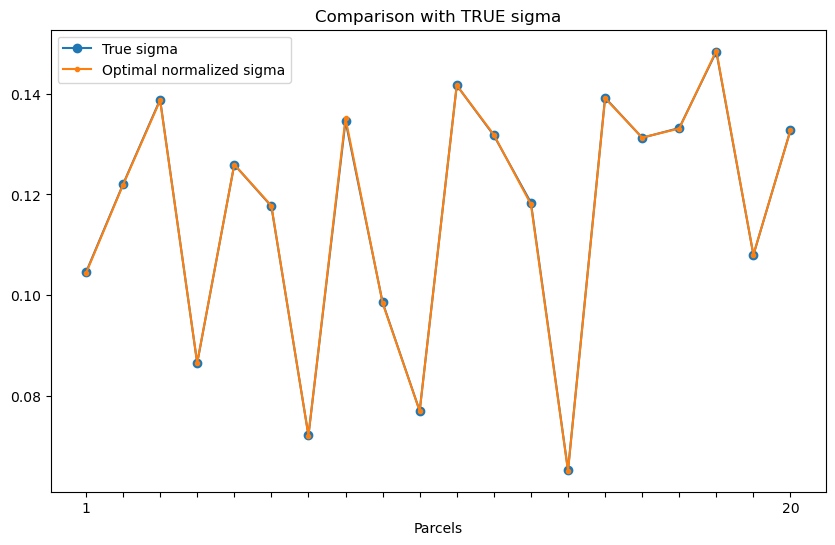

In [100]:
plt.figure(figsize=(10,6))
plt.title('Comparison with TRUE sigma')
plt.plot(range(1, NPARCELS+1), sigma_emp, 'o-', label='True sigma')
plt.plot(range(1, NPARCELS+1), sigma_normalized, '.-', label='Optimal normalized sigma')
plt.xlabel('Parcels')
ticks = np.arange(1, NPARCELS + 1)
labels = [str(ticks[0])] + [''] * (len(ticks) - 2) + [str(ticks[-1])]
plt.xticks(ticks,labels)
plt.legend()
plt.show()

### Step 4: Verify the Results

In [101]:
# Compute the final FC and COVtau using the sigma_normalized
FC_final, COVsim, COVsimtotal, A = hopf_int(gC, f_diff, sigma_normalized)
COVtausim = (expm((Tau * TR) * A) @ COVsimtotal)[:NPARCELS, :NPARCELS].copy()

# Normalize COVtausim
sigratiosim = np.zeros((NPARCELS, NPARCELS))
for i in range(NPARCELS):
    for j in range(NPARCELS):
        sigratiosim[i, j] = 1 / np.sqrt(COVsim[i, i]) / np.sqrt(COVsim[j, j])
COVtausim *= sigratiosim

# Print results
# print("Final FC:")
# print(FC_final)
# print("Empirical FC:")
# print(FCemp)
print("Difference (FC Frobenius norm):", np.linalg.norm(FC_final - FCemp, ord='fro'))

# print("\nFinal COVtau:")
# print(COVtausim)
# print("Empirical COVtau:")
# print(COVtauemp)
print("Difference (COVtau Frobenius norm):", np.linalg.norm(COVtausim - COVtauemp, ord='fro'))

Difference (FC Frobenius norm): 0.0006896684675956557
Difference (COVtau Frobenius norm): 0.00011951734448266447


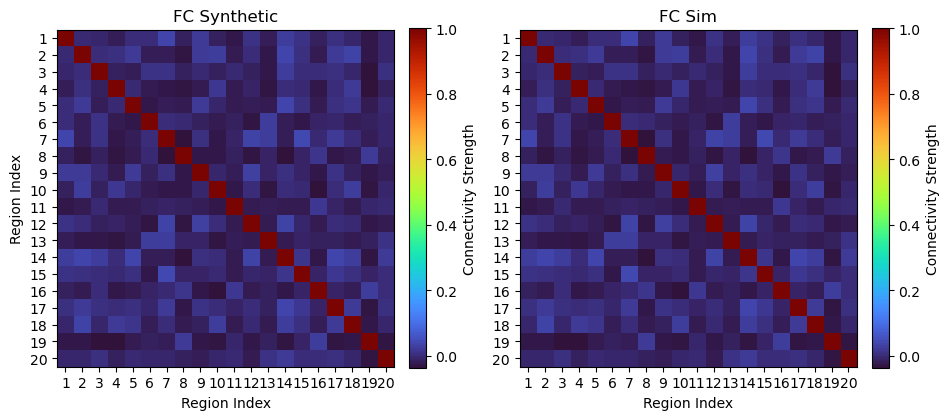

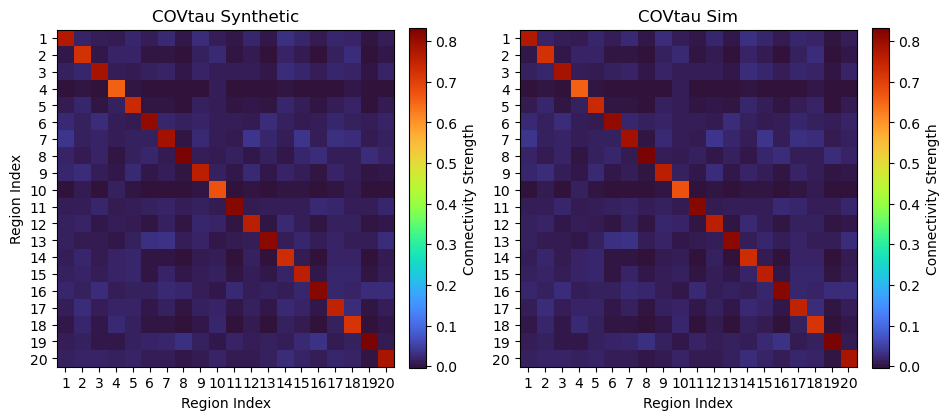

In [ ]:
FCsim, COVsim, COVsimtotal, A = [arr.copy() for arr in hopf_int(gC, f_diff, sigma_normalized)]

plot_FC_matrices(FCemp, FCsim, title1="FC Synthetic", title2="FC Sim", cmap="turbo", size=1.2)
plot_FC_matrices(COVtauemp, COVtausim, title1="COVtau Synthetic", title2="COVtau Sim", cmap="turbo", size=1.2)